In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow_addons.optimizers import CyclicalLearningRate
import sklearn
import sklearn.metrics
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use("seaborn")

## Database: connect and get partitioned data

Size of training data: (14637, 1000)
Size of validation data: (1829, 1000)
Size of testing data: (1830, 1000)
number of samples per time series: 1000
Categories: {'SR': 0, 'AFIB': 1}


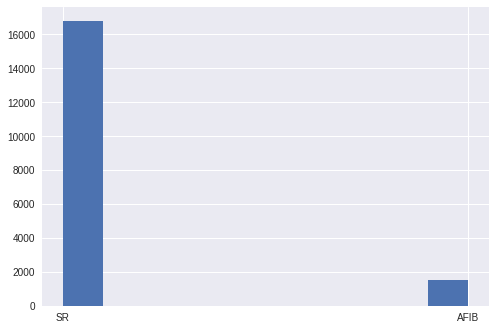

In [2]:
%run database.ipynb
ecg_db = connect()
(X_train, X_test, X_val), (y_train, y_test, y_val) = get_data(ecg_db)

## initialize helper functions, normalize time series

In [ ]:
%run helper_functions.ipynb
X_train, X_test, X_val = normalize_data(X_train, X_test, X_val, method=4)

In [ ]:
(X_train, X_test, X_val), (y_train, y_test, y_val) = fix_shape_conv((X_train, X_test, X_val), (y_train, y_test, y_val)) 
print(X_train.shape, y_train.shape)

In [ ]:
# Copied from https://github.com/avanwyk/tensorflow-projects/blob/master/lr-finder/lr_finder.py
# Apache License 2.0

from tensorflow.keras.callbacks import Callback

class LRFinder(Callback):
    """`Callback` that exponentially adjusts the learning rate after each training batch between `start_lr` and
    `end_lr` for a maximum number of batches: `max_step`. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the `plot` method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

In [ ]:
def pretty_plot(history, field, fn):
    def plot(data, val_data, best_index, best_value, title):
        plt.plot(range(1, len(data)+1), data, label='train')
        plt.plot(range(1, len(data)+1), val_data, label='validation')
        if not best_index is None:
            plt.axvline(x=best_index+1, linestyle=':', c="#777777")
        if not best_value is None:
            plt.axhline(y=best_value, linestyle=':', c="#777777")
        plt.xlabel('Epoch')
        plt.ylabel(field)
        plt.xticks(range(0, len(data), 20))
        plt.title(title)
        plt.legend()
        plt.show()

    data = history.history[field]
    val_data = history.history['val_' + field]
    tail = int(0.15 * len(data))

    best_index = fn(val_data)
    best_value = val_data[best_index]

    plot(data, val_data, best_index, best_value, "{} over epochs (best {:06.4f})".format(field, best_value))
    plot(data[-tail:], val_data[-tail:], None, best_value, "{} over last {} epochs".format(field, tail))

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


## ResNet model

### define ResNet model of https://github.com/spdrnl/ecg/blob/master/ECG.ipynb

In [ ]:
def build_resnet_model(categories=2, input_size=1000):
    def residual_block(X, filters, kernel_size):
        out = keras.layers.Conv1D(filters, kernel_size, padding='same')(X)
        out = keras.layers.ReLU()(out)
        out = keras.layers.Conv1D(filters, kernel_size, padding='same')(out)
        out = keras.layers.add([X, out])
        out = keras.layers.ReLU()(out)
        out = keras.layers.MaxPool1D(5, 2)(out)
        return out

    filters = 32
    kernel_size = 5

    inputs = keras.layers.Input([input_size, 1])
    X = keras.layers.Conv1D(filters, kernel_size)(inputs)
    X = residual_block(X, filters, kernel_size)
    X = residual_block(X, filters, kernel_size)
    X = residual_block(X, filters, kernel_size)
    X = residual_block(X, filters, kernel_size)
    X = residual_block(X, filters, kernel_size)
    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(32, activation='relu')(X)
    X = keras.layers.Dense(32, activation='relu')(X)
    output = (keras.layers.Dense(1, activation='sigmoid')(X) if categories == 2 else keras.layers.Dense(categories, activation='softmax')(X))

    model = keras.Model(inputs=inputs, outputs=output)
    return model

### compile model

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.001)
model = build_resnet_model(input_size=X_train.shape[1])
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()
# lr_finder = LRFinder(start_lr=1e-7, end_lr= 1e-03, max_steps=100, smoothing=0.6)
# _ = model.fit(X_train, y_train, batch_size=256, epochs=5, callbacks=[lr_finder], verbose=False)

# lr_finder.plot()

### setup and run training

In [ ]:
# Set cyclical learning rate
N = X_train.shape[0]
batch_size = 128
iterations = N/batch_size
step_size= 2 * iterations

lr_schedule = CyclicalLearningRate(1e-6, 1e-3, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

save_best_weights = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                           shuffle=True, batch_size=batch_size, epochs=75, callbacks=[save_best_weights])

### plot metrics

In [ ]:
pretty_plot(history, 'loss', lambda x: np.argmin(x))

In [ ]:
pretty_plot(history, 'accuracy', lambda x: np.argmax(x))

### test trained network with testing data

In [ ]:
weights_path = "weights.hdf5"
model.load_weights(weights_path)
model.evaluate(X_test, y_test)

In [ ]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["SR", "AFIB"],
                      title="Confusion matrix")